### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.data.some_dataloader import *
import matplotlib.pyplot as plt
from article_to_country import *
import statsmodels.formula.api as smf
from plots import *

# <span style="color:#9689d6">ADA - Class Project</span>

## Team: Les Fraises TagADA
    Petit-Phar Oriane
    Friedrich Claire
    Gotti Bryan
    Théo Schifferli
    Jérémy Barghorn

# Table of contents : 

- [1. Are there cultural biases intrinsic to the Wikipedia graph?](#1-are-there-cultural-biases-intrinsic-to-the-wikipedia-graph)
    - [1.1 What countries are the most present in the Wikipedia graph](#11-what-countries-are-the-most-present-in-the-wikipedia-graph)
    - [1.2 Are articles about some countries on average more connected than others](#12-are-articles-about-some-countries-on-average-more-connected-than-others)
- [2. Are there cultural biases in the way players play Wikispeedia?](#2-are-there-cultural-biases-in-the-way-players-play-wikispeedia)
    - [2.1 What articles are most often clicked on? How does this relate to the country of the article?](#21-what-articles-are-most-often-clicked-on-how-does-this-relate-to-the-country-of-the-article)
    - [2.2 What paths do Wikispeedia players most follow? Are there "highway paths" that are very often used? Can this be linked to a cultural bias?](#22-what-paths-do-wikispeedia-players-most-follow-are-there-highway-paths-that-are-very-often-used-can-this-be-linked-to-a-cultural-bias)
    - [2.3 What articles are most likely to cause a player to stop the game? What makes those articles "dead ends"? What does this have to do with the country of these articles?](#23-what-articles-are-most-likely-to-cause-a-player-to-stop-the-game-what-makes-those-articles-dead-ends-what-does-this-have-to-do-with-the-country-of-these-articles)
- [3. How can we explain the players' biases?](#3-how-can-we-explain-the-players-biases)
    - [3.1 Does it simply derive from the fact that the Wikipedia graph is already biased in itself?](#31-does-it-simply-derive-from-the-fact-that-the-wikipedia-graph-is-already-biased-in-itself)
    - [3.2 What is the distribution of countries among start / target articles for the Wikispeedia games? If it is not balanced, could this be an explanation?](#32-what-is-the-distribution-of-countries-among-start--target-articles-for-the-wikispeedia-games-if-it-is-not-balanced-could-this-be-an-explanation)
    - [3.3 Is there something inherent to the way players play the game?](#33-is-there-something-inherent-to-the-way-players-play-the-game)


# 1. Are there cultural biases intrinsic to the Wikipedia graph?


## 1.1 What countries are the most present in the Wikipedia graph

First a naive approach is used by doing a text search and finding all the country string names inside the plaintext. This is done with help of a regex that matches all the countries in all the files. The results are then parsed in a table containing as index the article name and as columns all the possible countries on earth along with the number of occurences in the specific article. The following cell is doing this and should take arround 4min to run.

In [3]:
country_data = country_occurences_in_files()
counts = filter_top_k(country_data, k=2, N=1)

4604it [04:33, 16.82it/s]


This table is then used in order to find the top K countries inside an article with at least N occurences

Text(0.5, 0.98, 'NaN Counts in Top 5 Countries Across Different Sample Sizes. This shows how many articles were not classified to any country after regex filtering')

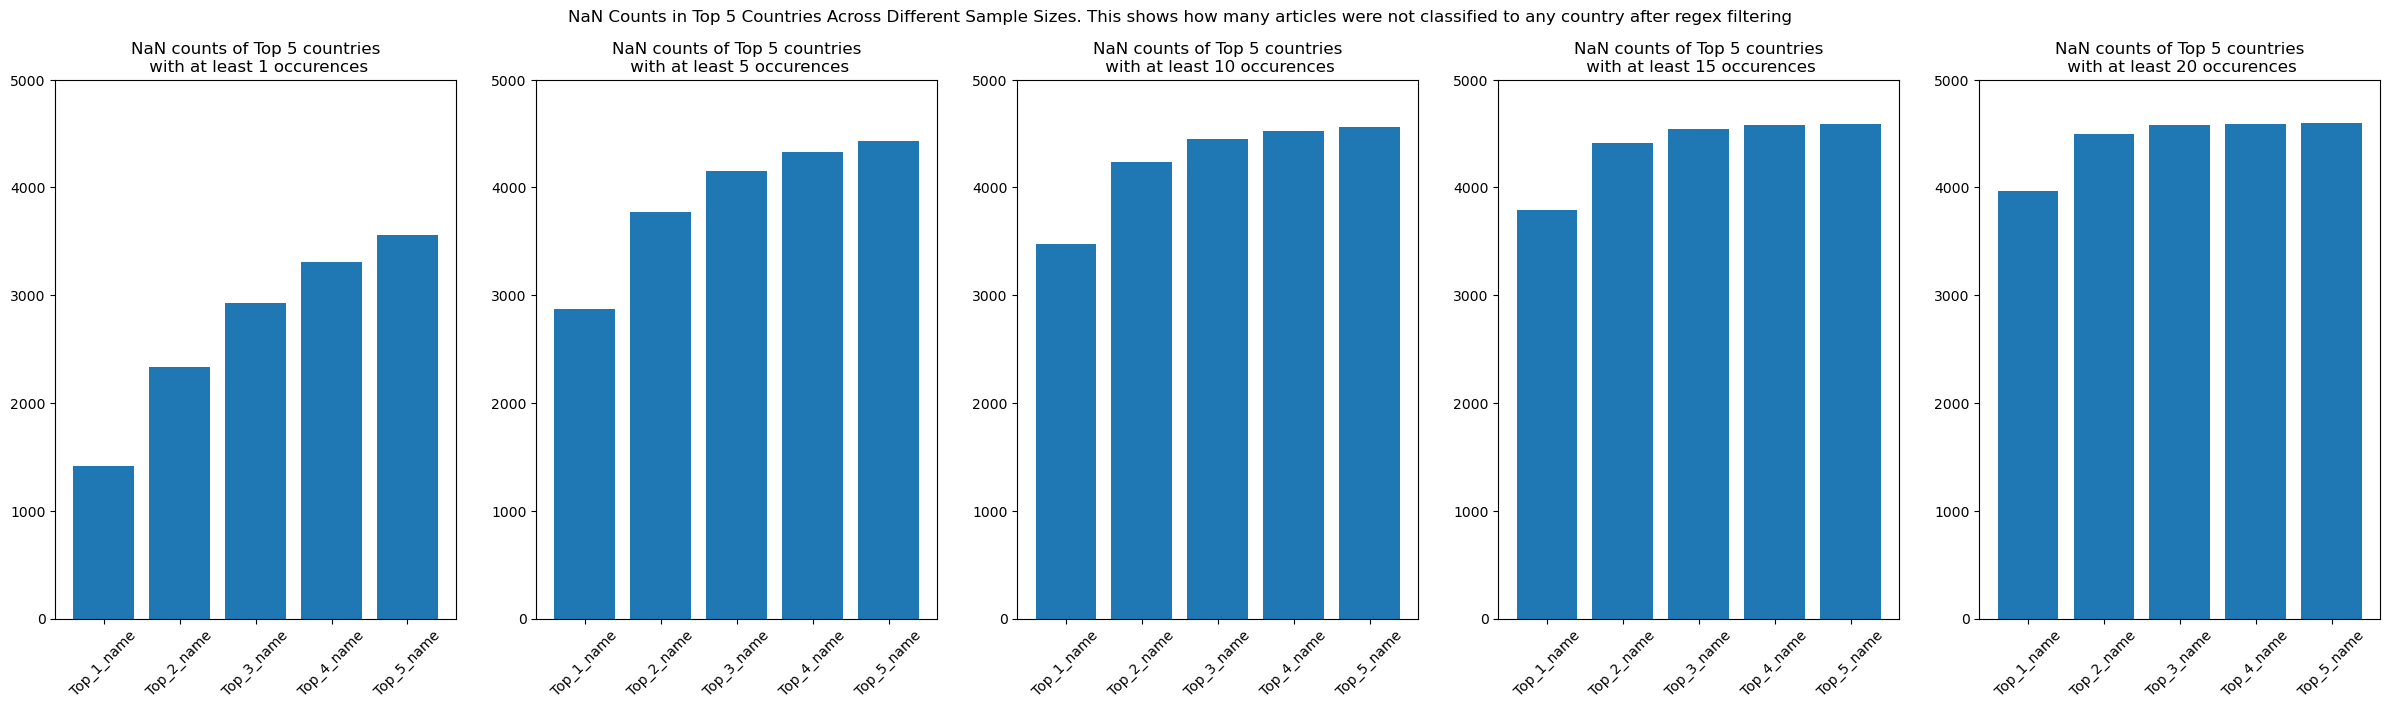

In [11]:
N_samples = [1, 5, 10, 15, 20]
K = 5

fig, axs = plt.subplots(1, len(N_samples), figsize=(30, 7))

i = 0
for j, N in enumerate(N_samples):
    counts = filter_top_k(country_data, k=K, N=N)
    df_cleaned = counts.iloc[:, :K]
    df_stat = df_cleaned.isna().sum()
    axs[j].bar(df_stat.index, df_stat)
    axs[j].set_title(f"NaN counts of Top {K} countries\n with at least {N} occurences")
    axs[j].set_ylim(0, 5000)
    axs[j].xaxis.set_tick_params(rotation=45)
fig.suptitle("NaN Counts in Top 5 Countries Across Different Sample Sizes. This shows how many articles were not classified to any country after regex filtering")

From the previous cell it was clear that in order to classify the maximum number of articles we needed to pick a small number of occurences (N = 1) in order to avoid discarding more than half of the articles. 

In [12]:
counts = filter_top_k(country_data, k=2, N=1)
nan_df = counts[counts.isna().all(axis=1)]
print(f"Number of articles with no countries before completion with llama: {len(nan_df)}")


Number of articles with no countries before completion with llama: 1412


This approach resulted in 1412 articles having no country assigned to them. By going manually through them it can be seen that as a human some articles can be further classified to countries even if the country name is not explicetly mentionned in the text. 

### Further classifying articles to countires with the help of small llm's

Two LLM's were tested and only Llama (a Meta LLM) was retained in order to assign the missing articles to countries. Fot this to be done the LLM was downloaded locally and used for inference on the plaintext articles. 

The format of the prompt used to let the model classify articles to countries was : 
```
<system_prompt_begin>
You will be given textual articles. For each article provide single and unique country to which the article is related and should be classified to. Provide the answer in the form : <country>. If there is no country related to the article, please write 'None'. If the location is not on earth, please write 'None'. You must be 100\% sure this is a question of life or death.
<system_prompt_end>

<user_prompt_begin>
plaintext article
<user_prompt_end>
```

Run this execute the following cell : 
(Note : It was already preprocessed so this can also be skipped and the  ```data/country_occurences.csv``` can be loaded)

In [13]:
# !python article_to_country.py

In [14]:
refined_data = pd.read_csv("data/country_occurences.csv", index_col=0)
nan_df = refined_data[refined_data.isna().all(axis=1)]
print(f"Number of articles with no countries after completion with llama: {len(nan_df)}")

Number of articles with no countries after completion with llama: 887


This approach allowed to classify 1412 - 887 = 525 new articles having a country assigned to them. In the cell below it can be seen which articles were classified with help of the LLM (the ones having a "Top_1_count" of 0 meaning 0 occurences of this exact substring in the text but still classified as this country by the llm)

In [15]:
refined_data[refined_data["Top_1_count"] == 0].head(10)

,Top_1_name,Top_2_name,Top_1_count,Top_2_count
1980_eruption_of_Mount_St._Helens,united states,NaN,0.0,NaN
4-2-0,united states,NaN,0.0,NaN
4-4-0,united states,NaN,0.0,NaN
4-6-0,united states,NaN,0.0,NaN
4th_century,india,NaN,0.0,NaN
6-2-0,united states,NaN,0.0,NaN
8th_century,united kingdom,NaN,0.0,NaN
Aardvark,south africa,NaN,0.0,NaN
Abbadid,spain,NaN,0.0,NaN
Abstract_art,russia,NaN,0.0,NaN


Text(0.5, 1.0, 'Top 40 countries occurences in the articles')

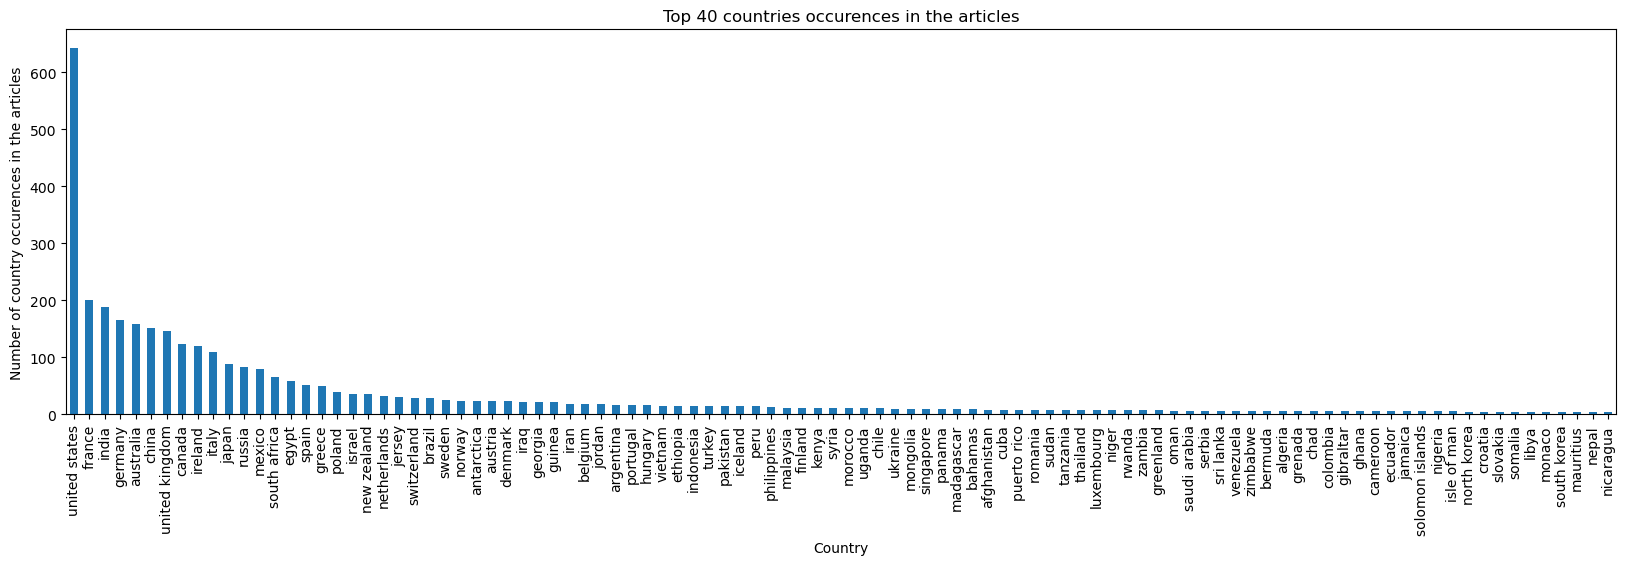

In [21]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=False).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Top 40 countries occurences in the articles")

Text(0.5, 1.0, 'Bottom 40 countries occurences in the articles')

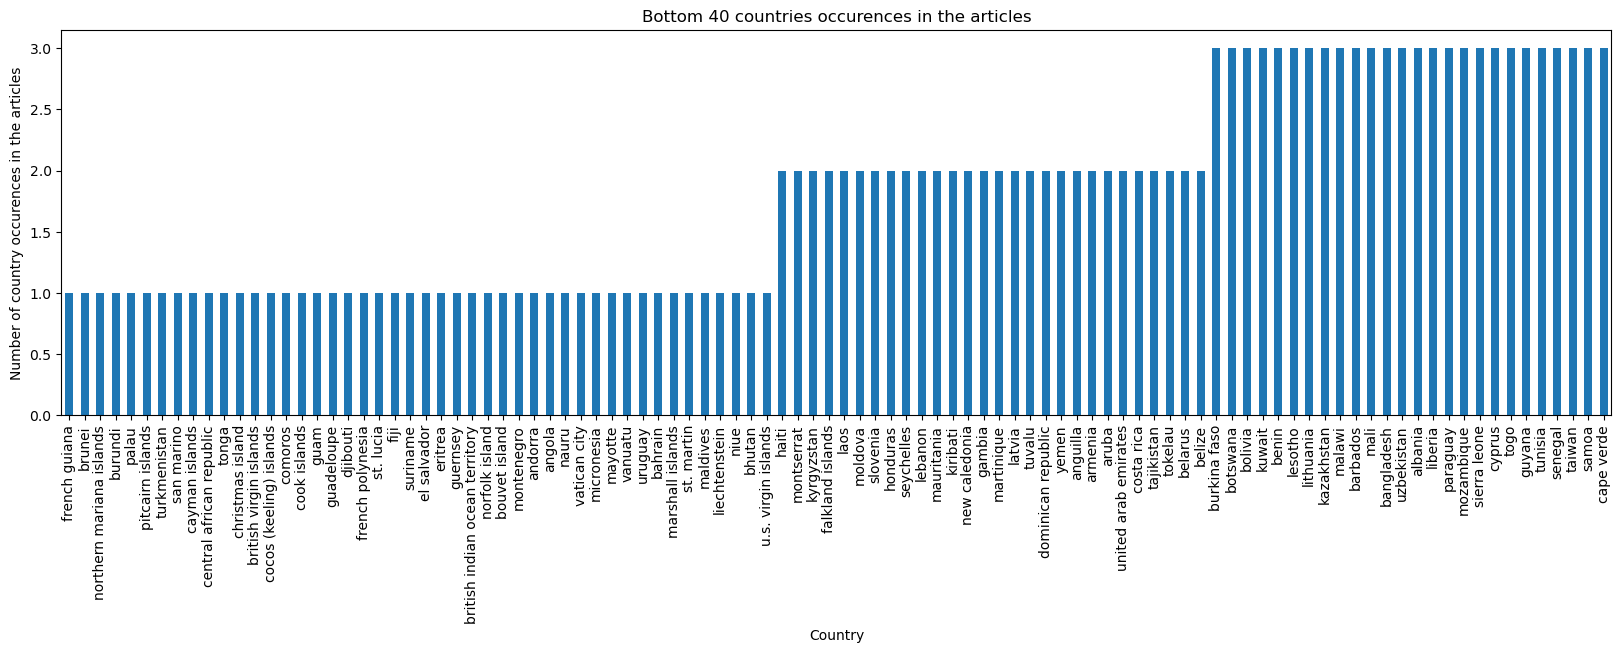

In [20]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=True).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Bottom 40 countries occurences in the articles")

## 1.2 Are articles about some countries on average more connected than others


# 2. Are there cultural biases in the way players play Wikispeedia?


## 2.1 What articles are most often clicked on? How does this relate to the country of the article?


## 2.2 What paths do Wikispeedia players most follow? Are there "highway paths" that are very often used? Can this be linked to a cultural bias?


## 2.3 What articles are most likely to cause a player to stop the game? What makes those articles "dead ends"? What does this have to do with the country of these articles?


# 3. How can we explain the players' biases?


## 3.1 Does it simply derive from the fact that the Wikipedia graph is already biased in itself?

#### Articles country to outgoing links countries

First we will see what are the links between the country of one article comapred to the destination country of it's outgoing links. 

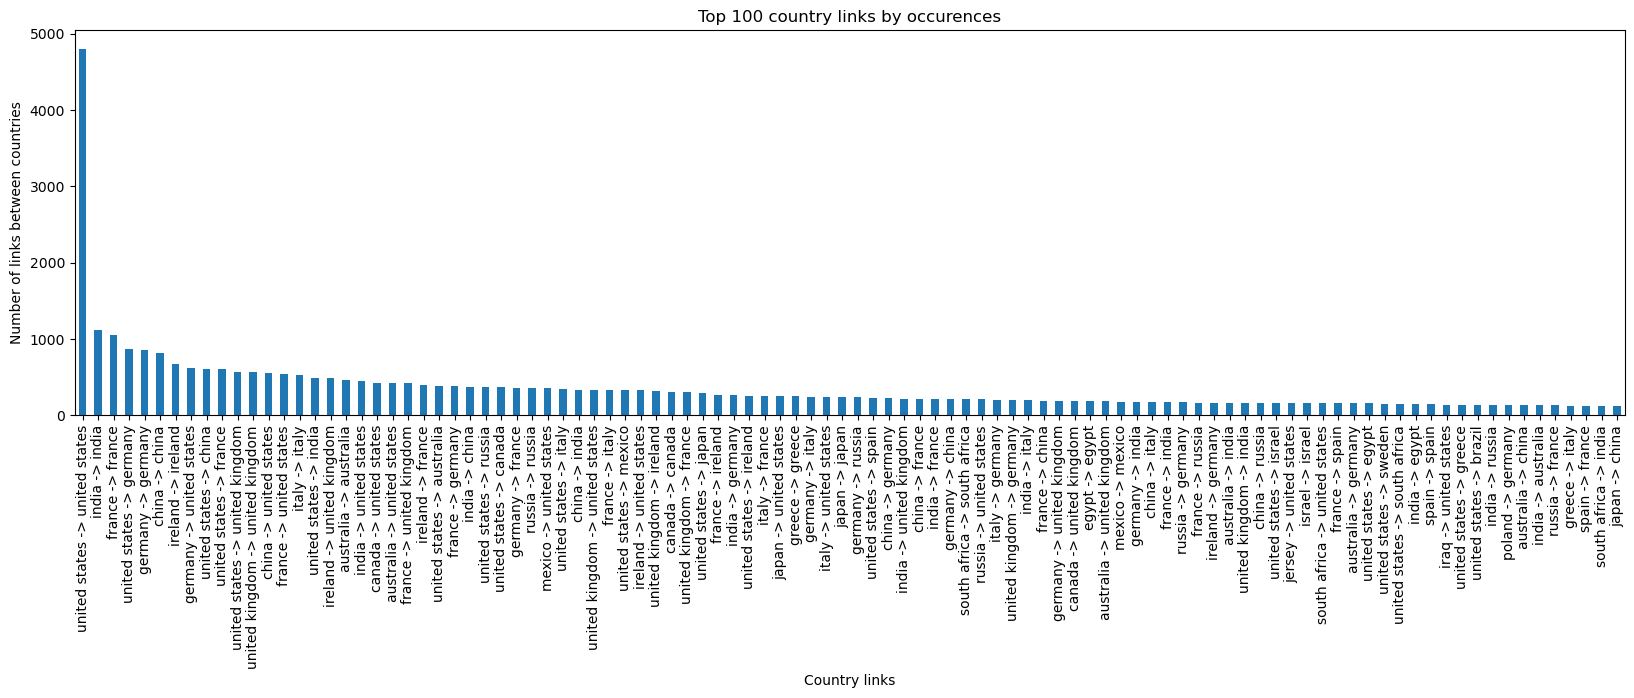

In [22]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
plot_country_to_country(country_clicks)

It can be seen that articles of one country are always strongly interconnected. In the sense that once the user is inside articles assigned to a specific country, they have larger chances to stay in articles of the sam country by clicking on links to navigate to other articles. This can be observed by the fact that there are many connections of the form "france" -> "france" that are occuring and have higher counts than connections "france" -> "other country"

### Statistical analysis trying to estimate the number of clicks an article gets

The first approach is based on the fact that we observed that a lot of articles are classified into 2 predominant countries categories. We thus thought that the country category could have an impact on the number of clicks an article is getting. 
We used an ordinary least squares solver in order to describe this data and tried to predict : 
```click_count ~ num_links_in + num_links_out + C(Top_1_name)```
The number of incoming/outgoing links can also be seen as a useful feature in order to predict the number of clicks an article recieves so this is why there are also included. 
In this case neither num_links_in, num_links_out or click_count were normalized since it is more intuitive to have coefficients in terms of clicks than in term of probabilities. In case the outputs need to be normalized, uncomment the following lines

In [23]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
# country_clicks["click_count"] = country_clicks["click_count"] / country_clicks["click_count"].sum()
# country_clicks["num_links_in"] = (country_clicks["num_links_in"] - country_clicks["num_links_in"].mean()) / country_clicks["num_links_in"].std()
# country_clicks["num_links_out"] = (country_clicks["num_links_out"] - country_clicks["num_links_out"].mean()) / country_clicks["num_links_out"].std()

In [24]:
mod = smf.ols(formula='click_count ~ num_links_in + num_links_out + C(Top_1_name)', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     29.99
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:15:28   Log-Likelihood:                -22346.
No. Observations:                3330   AIC:                         4.512e+04
Df Residuals:                    3116   BIC:                         4.643e+04
Df Model:                         213                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

By analysing the coefficients we see that we can reject the fact that the countires have a meaningful impact on the number of clicks an article recieves at a significant level.
Given the results the only variable we can't reject at a significant level is the ```num_links_in```. We will thus further analyse this with a simpler model :  
```click_count ~ num_links_in```

In [25]:
mod = smf.ols(formula='click_count ~ num_links_in', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     7054.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:15:29   Log-Likelihood:                -27772.
No. Observations:                4135   AIC:                         5.555e+04
Df Residuals:                    4133   BIC:                         5.556e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.5745      3.399     -2.523   

In this case it can be seen that the both the intercept and the num_links_in coefficients are significant at 85% and are thus significant in order to predict the number of clicks an articles recieves. This means that the number of incoming links is related to the number of clicks an article has and moreover each incoming link increases the chance of an article to be clicked by nearly 4. 

We will provide a last analysis trying to see if the number of outgoing links are significant to the number of clicks an article recieves. 
The formula used for this is : ```click_count ~ num_links_in * num_links_out``` so that the cross term is also present.

In [26]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='click_count ~ num_links_in * num_links_out', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     4282.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:15:30   Log-Likelihood:                -26870.
No. Observations:                4129   AIC:                         5.375e+04
Df Residuals:                    4125   BIC:                         5.377e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

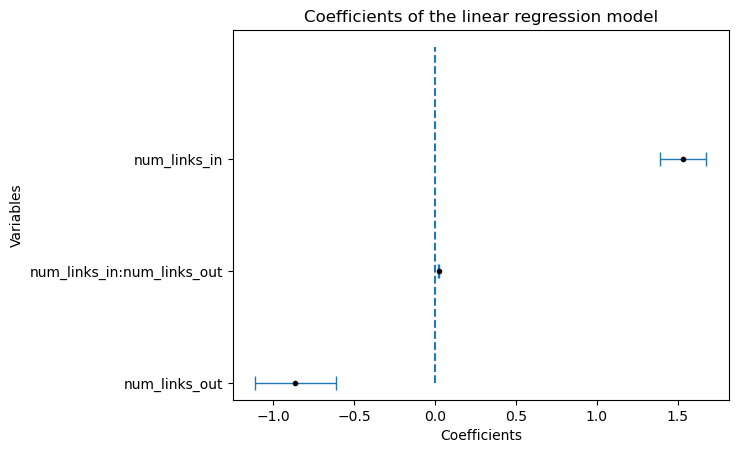

In [27]:
plot_res_stats_model(res)

The results suggest that the number of incoming and outgoing links, as well as the interaction between them, significantly contribute to predicting the click count on an article. Specifically:

Number of Incoming Links (num_links_in): Each additional incoming link is associated with an increase of approximately 1.53 clicks on average (coefficient: 1.53). This positive coefficient implies that the more links pointing to an article, the higher its visibility and the potential clicks it receives. This effect is statistically significant with a very low p-value (<0.001).

Number of Outgoing Links (num_links_out): Each outgoing link reduces the click count by about 0.86 clicks (coefficient: -0.86), suggesting that articles with more outgoing links may divert readers attention away, leading to fewer clicks. This negative effect is also statistically significant (p < 0.001).

Interaction between Incoming and Outgoing Links (num_links_in:num_links_out): The positive interaction term (coefficient: 0.021) indicates that articles with both high incoming and outgoing links experience a slightly amplified effect on click count. This means that for articles with many incoming links, the negative effect of outgoing links is somewhat mitigated. This subtle effect is also significant (p < 0.001).

Overall Model Fit
R-squared: The R-squared value of 0.758 suggests that approximately 75.8% of the variance in click counts is explained by this model, which indicates a good fit.
F-statistic: The high F-statistic (~5000) with a p-value near zero confirms that the model is statistically significant overall.

## 3.2 What is the distribution of countries among start / target articles for the Wikispeedia games? If it is not balanced, could this be an explanation?

### Analysis of the countries relations between the start and the end of finished paths.

In [30]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].fillna("[]")
country_clicks["num_links_in"] = country_clicks["num_links_in"].fillna(0)
country_clicks["num_links_out"] = country_clicks["num_links_out"].fillna(0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].apply(literal_eval)

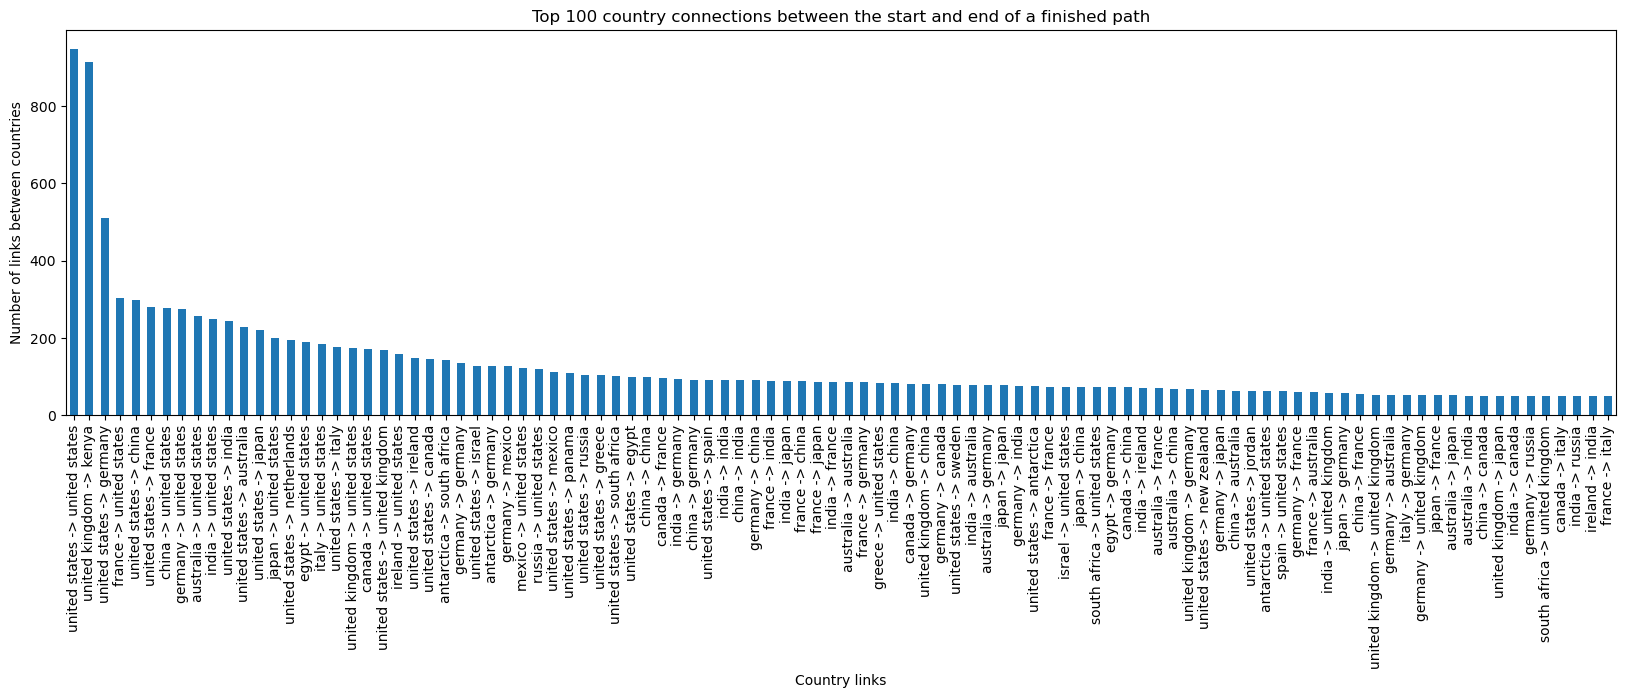

In [31]:
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()

finished_paths["path"] = finished_paths["path"].str.split(";")
unfinished_paths["path"] = unfinished_paths["path"].str.split(";")

paths_to_country(finished_paths, country_clicks, finished=True)
    

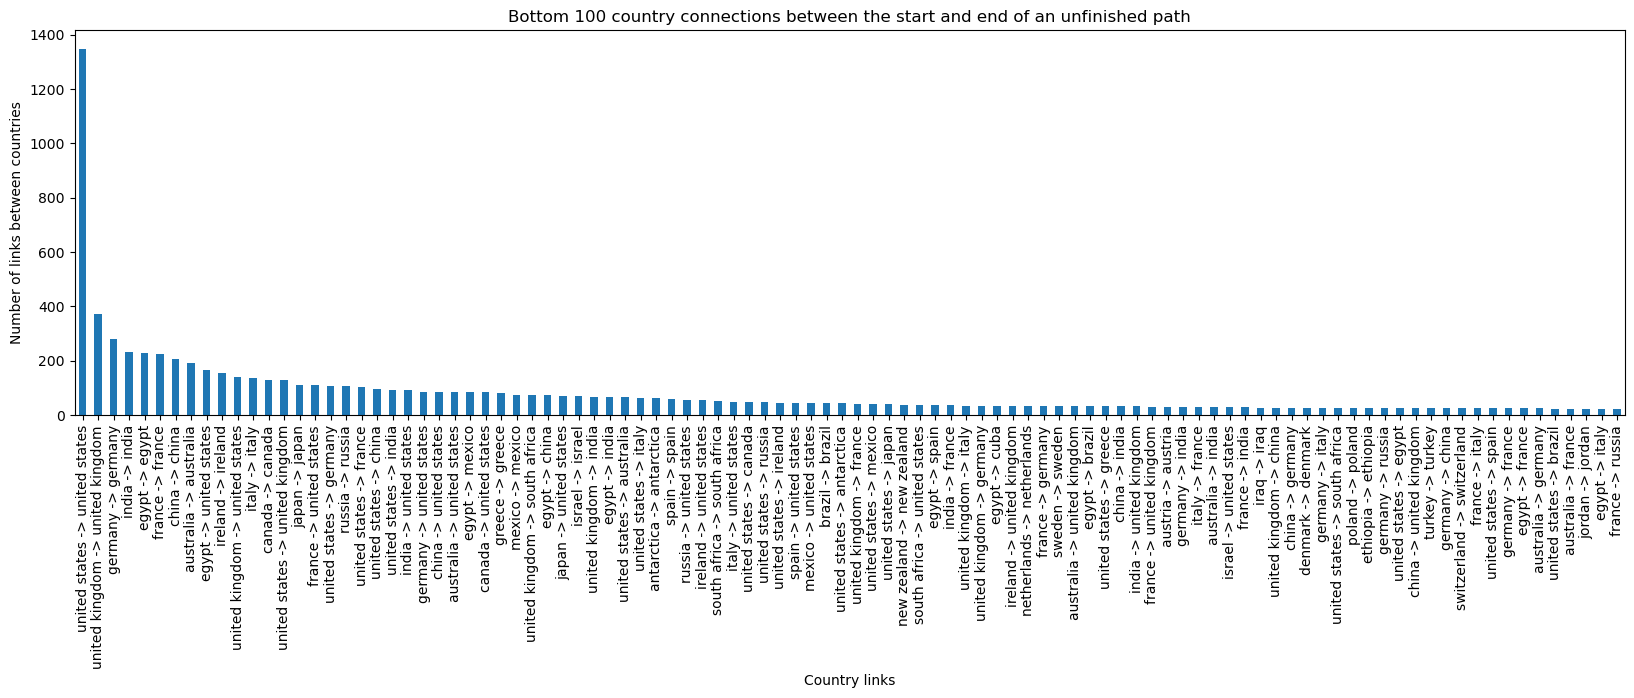

In [33]:
paths_to_country(unfinished_paths, country_clicks, finished=False)


Unfinished paths often remain within the same country, meaning the starting and ending points of these paths are typically in the same location. This pattern suggests that players struggle to navigate away from the country where they begin, likely because the initial article is somewhat isolated from the rest of the network, making it harder to reach articles in other countries. In contrast, finished paths display more international diversity; while there is a prominent cluster of games beginning and ending in the United States, many other paths successfully transition from one country to another, reflecting a broader range of connections across the graph.

In [ ]:
country_clicks[['num_links_in', 'num_links_out','click_count']].corr()

## 3.3 Is there something inherent to the way players play the game?
